# 两层神经网络
### 每个神经元用 tanh 函数激活，目前考虑需要对数据预处理：归一化，PCA和白化
### 权重初始化考虑 Kaiming He 的方法，
### 要加入L2正则项（暂时不用）
### 对每个神经元模块化设计

In [1]:
# 获取 CIFAR-10 数据集，并且处理成为train,validation,test 三部分
import numpy as np
import torch
import random
import pickle
import matplotlib.pyplot as plt
# 加载 CIFAR-10 数据集
# 这里使用的是CIFAR-10 的 data_batch_1 共一万个数据，我自己划分为 train,validation,test 三部分
# 前 6000 为training set，接着3000为 validation set 最后1000为 test set

def load_train_data(filename):
    with open(filename,'rb') as f:
        datadict = pickle.load(f,encoding = 'latin1')
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000,3,32,32)
        Y = np.array(Y)
        return X,Y
    
    
root = 'data_batch_1'
(data, labels) = load_train_data(root)

train_set = data[0:3000]
train_labels = labels[0:3000]

val_set = data[6000:7000]
val_labels = labels[6000:7000]

test_set = data[9000:9500]
test_labels = labels[9000:9500]

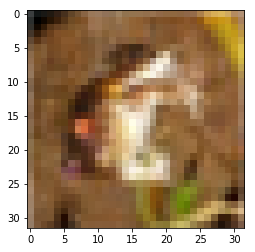

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


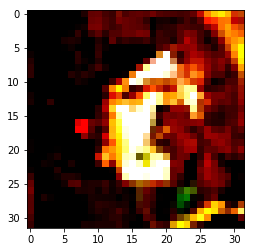

In [2]:
# 对训练集进行预处理
# 数据可视化
data = train_set[0].T
plt.figure()
plt.imshow(data)
plt.show()

## 归一化
train_set = train_set - np.mean(train_set,axis = 0)
train_set = train_set / np.std(train_set,axis = 0)

# 数据可视化
data = train_set[0].T
plt.figure()
plt.imshow(data)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 32, 3)


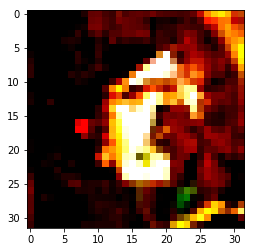

In [3]:
## PCA 降维和白化
# 经过了归一化处理后，数据已经是零均值了,白化有点问题，暂时取消
train_set = train_set.reshape((train_set.shape[0],3072))
cov = np.dot(train_set.T,train_set) / train_set.shape[0] # 协方差矩阵,是半正定的 3072 * 3072
U,S,V = np.linalg.svd(cov)  # SVD 分解,U是对应的特征向量，S是特征值对角阵且由大到小排列
# 选择主成分个个数为 16 * 16 * 3，组成降维矩阵 P
train_set = np.dot(train_set,U[:,:3072])
#train_set = train_set / np.sqrt(S[:] + 0)

# 数据可视化,观察降维结果
datas = train_set.dot(U[:,:3072].T)
data = datas[0].reshape(3,32,32).T
print(np.shape(data))
plt.figure()
img = data
plt.imshow(img)
plt.show()

In [4]:
## 两层神经网络搭建
## 太难写了，还是用 torch 框架吧
import torch
from torch.autograd import Variable
import torch.nn.functional as F
class two_layers_neural_networks(torch.nn.Module):
    def __init__(self,n_feature,n_hidden,n_output):
        super(two_layers_neural_networks, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)
        self.output = torch.nn.Linear(n_hidden, 10)
        
    def forward(self, train_set):
        data = F.softmax(self.hidden(train_set))
        data = self.output(data)
        return data
        
    

In [5]:
## 初始化权重
# weight = 
# bias = 
# rate = 
# iteration = 
print(np.shape(train_set))
net = two_layers_neural_networks(3072,100,10)
print(net)


(3000, 3072)
two_layers_neural_networks(
  (hidden): Linear(in_features=3072, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=10, bias=True)
)


In [6]:
optimizer = torch.optim.SGD(net.parameters(),lr=0.5)
loss_func = torch.nn.CrossEntropyLoss()
train_labels = torch.tensor(train_labels, dtype=torch.long)
train_set = torch.tensor(train_set, dtype=torch.float32)
x, y = Variable(train_set), Variable(train_labels)

# 开始训练
for iteration in range(1000):
    out = net(train_set)
    
    loss = loss_func(out,train_labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    prediction = torch.max(F.softmax(out),1)[1]   
    pred_y = prediction.data.numpy().squeeze()
    target_y = train_labels.data.numpy()
    print('iteration:\t%s\tloss:\t%s\n' % (iteration, loss.data))
    print('accuraccy in train_set:\t%s' % (np.sum(target_y == pred_y) / target_y.shape[0]))

E:\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
E:\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


iteration:	0	loss:	tensor(2.3042)

accuraccy in train_set:	0.09966666666666667
iteration:	1	loss:	tensor(2.3035)

accuraccy in train_set:	0.09966666666666667
iteration:	2	loss:	tensor(2.3028)

accuraccy in train_set:	0.09966666666666667
iteration:	3	loss:	tensor(2.3022)

accuraccy in train_set:	0.09966666666666667
iteration:	4	loss:	tensor(2.3015)

accuraccy in train_set:	0.09966666666666667
iteration:	5	loss:	tensor(2.3009)

accuraccy in train_set:	0.09966666666666667
iteration:	6	loss:	tensor(2.3002)

accuraccy in train_set:	0.1
iteration:	7	loss:	tensor(2.2996)

accuraccy in train_set:	0.09933333333333333
iteration:	8	loss:	tensor(2.2990)

accuraccy in train_set:	0.104
iteration:	9	loss:	tensor(2.2983)

accuraccy in train_set:	0.11133333333333334
iteration:	10	loss:	tensor(2.2975)

accuraccy in train_set:	0.116
iteration:	11	loss:	tensor(2.2966)

accuraccy in train_set:	0.126
iteration:	12	loss:	tensor(2.2956)

accuraccy in train_set:	0.135
iteration:	13	loss:	tensor(2.2945)

accura


accuraccy in train_set:	0.25333333333333335
iteration:	115	loss:	tensor(2.0281)

accuraccy in train_set:	0.264
iteration:	116	loss:	tensor(2.0267)

accuraccy in train_set:	0.25633333333333336
iteration:	117	loss:	tensor(2.0238)

accuraccy in train_set:	0.267
iteration:	118	loss:	tensor(2.0225)

accuraccy in train_set:	0.25833333333333336
iteration:	119	loss:	tensor(2.0197)

accuraccy in train_set:	0.26866666666666666
iteration:	120	loss:	tensor(2.0184)

accuraccy in train_set:	0.25933333333333336
iteration:	121	loss:	tensor(2.0157)

accuraccy in train_set:	0.271
iteration:	122	loss:	tensor(2.0144)

accuraccy in train_set:	0.26266666666666666
iteration:	123	loss:	tensor(2.0117)

accuraccy in train_set:	0.2753333333333333
iteration:	124	loss:	tensor(2.0104)

accuraccy in train_set:	0.26666666666666666
iteration:	125	loss:	tensor(2.0077)

accuraccy in train_set:	0.2806666666666667
iteration:	126	loss:	tensor(2.0064)

accuraccy in train_set:	0.2683333333333333
iteration:	127	loss:	tensor(


accuraccy in train_set:	0.3416666666666667
iteration:	225	loss:	tensor(1.8388)

accuraccy in train_set:	0.3546666666666667
iteration:	226	loss:	tensor(1.8482)

accuraccy in train_set:	0.337
iteration:	227	loss:	tensor(1.8400)

accuraccy in train_set:	0.35333333333333333
iteration:	228	loss:	tensor(1.8331)

accuraccy in train_set:	0.3436666666666667
iteration:	229	loss:	tensor(1.8201)

accuraccy in train_set:	0.3596666666666667
iteration:	230	loss:	tensor(1.8187)

accuraccy in train_set:	0.35033333333333333
iteration:	231	loss:	tensor(1.8084)

accuraccy in train_set:	0.3606666666666667
iteration:	232	loss:	tensor(1.8054)

accuraccy in train_set:	0.3546666666666667
iteration:	233	loss:	tensor(1.8012)

accuraccy in train_set:	0.361
iteration:	234	loss:	tensor(1.8010)

accuraccy in train_set:	0.355
iteration:	235	loss:	tensor(1.8022)

accuraccy in train_set:	0.363
iteration:	236	loss:	tensor(1.8141)

accuraccy in train_set:	0.35033333333333333
iteration:	237	loss:	tensor(1.8120)

accuracc


accuraccy in train_set:	0.37933333333333336
iteration:	333	loss:	tensor(1.6899)

accuraccy in train_set:	0.39366666666666666
iteration:	334	loss:	tensor(1.6979)

accuraccy in train_set:	0.38166666666666665
iteration:	335	loss:	tensor(1.6883)

accuraccy in train_set:	0.39166666666666666
iteration:	336	loss:	tensor(1.7022)

accuraccy in train_set:	0.37833333333333335
iteration:	337	loss:	tensor(1.6931)

accuraccy in train_set:	0.3893333333333333
iteration:	338	loss:	tensor(1.7165)

accuraccy in train_set:	0.37233333333333335
iteration:	339	loss:	tensor(1.7020)

accuraccy in train_set:	0.38966666666666666
iteration:	340	loss:	tensor(1.7234)

accuraccy in train_set:	0.37133333333333335
iteration:	341	loss:	tensor(1.7349)

accuraccy in train_set:	0.38
iteration:	342	loss:	tensor(1.7256)

accuraccy in train_set:	0.37
iteration:	343	loss:	tensor(1.7404)

accuraccy in train_set:	0.379
iteration:	344	loss:	tensor(1.7143)

accuraccy in train_set:	0.37333333333333335
iteration:	345	loss:	tensor(


accuraccy in train_set:	0.3973333333333333
iteration:	441	loss:	tensor(1.6141)

accuraccy in train_set:	0.4126666666666667
iteration:	442	loss:	tensor(1.6123)

accuraccy in train_set:	0.4073333333333333
iteration:	443	loss:	tensor(1.6130)

accuraccy in train_set:	0.4083333333333333
iteration:	444	loss:	tensor(1.6362)

accuraccy in train_set:	0.395
iteration:	445	loss:	tensor(1.6290)

accuraccy in train_set:	0.4023333333333333
iteration:	446	loss:	tensor(1.6707)

accuraccy in train_set:	0.38266666666666665
iteration:	447	loss:	tensor(1.6328)

accuraccy in train_set:	0.4013333333333333
iteration:	448	loss:	tensor(1.6401)

accuraccy in train_set:	0.39566666666666667
iteration:	449	loss:	tensor(1.6316)

accuraccy in train_set:	0.4033333333333333
iteration:	450	loss:	tensor(1.6918)

accuraccy in train_set:	0.376
iteration:	451	loss:	tensor(1.6447)

accuraccy in train_set:	0.39866666666666667
iteration:	452	loss:	tensor(1.6712)

accuraccy in train_set:	0.384
iteration:	453	loss:	tensor(1.62


accuraccy in train_set:	0.3973333333333333
iteration:	549	loss:	tensor(1.6928)

accuraccy in train_set:	0.389
iteration:	550	loss:	tensor(1.6228)

accuraccy in train_set:	0.403
iteration:	551	loss:	tensor(1.6025)

accuraccy in train_set:	0.4026666666666667
iteration:	552	loss:	tensor(1.5919)

accuraccy in train_set:	0.414
iteration:	553	loss:	tensor(1.5860)

accuraccy in train_set:	0.4126666666666667
iteration:	554	loss:	tensor(1.5573)

accuraccy in train_set:	0.424
iteration:	555	loss:	tensor(1.5704)

accuraccy in train_set:	0.4166666666666667
iteration:	556	loss:	tensor(1.5565)

accuraccy in train_set:	0.423
iteration:	557	loss:	tensor(1.5614)

accuraccy in train_set:	0.418
iteration:	558	loss:	tensor(1.5535)

accuraccy in train_set:	0.422
iteration:	559	loss:	tensor(1.5441)

accuraccy in train_set:	0.429
iteration:	560	loss:	tensor(1.5360)

accuraccy in train_set:	0.425
iteration:	561	loss:	tensor(1.5346)

accuraccy in train_set:	0.4266666666666667
iteration:	562	loss:	tensor(1.532


accuraccy in train_set:	0.44466666666666665
iteration:	663	loss:	tensor(1.4892)

accuraccy in train_set:	0.43433333333333335
iteration:	664	loss:	tensor(1.4847)

accuraccy in train_set:	0.44166666666666665
iteration:	665	loss:	tensor(1.4852)

accuraccy in train_set:	0.43766666666666665
iteration:	666	loss:	tensor(1.4829)

accuraccy in train_set:	0.44266666666666665
iteration:	667	loss:	tensor(1.4842)

accuraccy in train_set:	0.43933333333333335
iteration:	668	loss:	tensor(1.4816)

accuraccy in train_set:	0.445
iteration:	669	loss:	tensor(1.4854)

accuraccy in train_set:	0.44
iteration:	670	loss:	tensor(1.4819)

accuraccy in train_set:	0.446
iteration:	671	loss:	tensor(1.4889)

accuraccy in train_set:	0.43933333333333335
iteration:	672	loss:	tensor(1.4938)

accuraccy in train_set:	0.44433333333333336
iteration:	673	loss:	tensor(1.5656)

accuraccy in train_set:	0.424
iteration:	674	loss:	tensor(1.6918)

accuraccy in train_set:	0.38
iteration:	675	loss:	tensor(1.6261)

accuraccy in train


accuraccy in train_set:	0.4593333333333333
iteration:	771	loss:	tensor(1.4745)

accuraccy in train_set:	0.44766666666666666
iteration:	772	loss:	tensor(1.4766)

accuraccy in train_set:	0.44866666666666666
iteration:	773	loss:	tensor(1.5211)

accuraccy in train_set:	0.43866666666666665
iteration:	774	loss:	tensor(1.5334)

accuraccy in train_set:	0.432
iteration:	775	loss:	tensor(1.5454)

accuraccy in train_set:	0.44166666666666665
iteration:	776	loss:	tensor(1.5262)

accuraccy in train_set:	0.43066666666666664
iteration:	777	loss:	tensor(1.5256)

accuraccy in train_set:	0.43866666666666665
iteration:	778	loss:	tensor(1.5017)

accuraccy in train_set:	0.444
iteration:	779	loss:	tensor(1.4663)

accuraccy in train_set:	0.455
iteration:	780	loss:	tensor(1.4492)

accuraccy in train_set:	0.458
iteration:	781	loss:	tensor(1.4491)

accuraccy in train_set:	0.4543333333333333
iteration:	782	loss:	tensor(1.4503)

accuraccy in train_set:	0.45766666666666667
iteration:	783	loss:	tensor(1.4626)

accu


accuraccy in train_set:	0.45666666666666667
iteration:	879	loss:	tensor(1.4962)

accuraccy in train_set:	0.444
iteration:	880	loss:	tensor(1.4825)

accuraccy in train_set:	0.45
iteration:	881	loss:	tensor(1.4972)

accuraccy in train_set:	0.453
iteration:	882	loss:	tensor(1.4712)

accuraccy in train_set:	0.45
iteration:	883	loss:	tensor(1.5490)

accuraccy in train_set:	0.43133333333333335
iteration:	884	loss:	tensor(1.4674)

accuraccy in train_set:	0.45066666666666666
iteration:	885	loss:	tensor(1.4412)

accuraccy in train_set:	0.4646666666666667
iteration:	886	loss:	tensor(1.4186)

accuraccy in train_set:	0.464
iteration:	887	loss:	tensor(1.4169)

accuraccy in train_set:	0.46366666666666667
iteration:	888	loss:	tensor(1.4075)

accuraccy in train_set:	0.466
iteration:	889	loss:	tensor(1.4058)

accuraccy in train_set:	0.4673333333333333
iteration:	890	loss:	tensor(1.4027)

accuraccy in train_set:	0.4686666666666667
iteration:	891	loss:	tensor(1.4015)

accuraccy in train_set:	0.468666666


accuraccy in train_set:	0.44966666666666666
iteration:	987	loss:	tensor(1.4644)

accuraccy in train_set:	0.44866666666666666
iteration:	988	loss:	tensor(1.5499)

accuraccy in train_set:	0.43433333333333335
iteration:	989	loss:	tensor(1.4094)

accuraccy in train_set:	0.47
iteration:	990	loss:	tensor(1.4022)

accuraccy in train_set:	0.4676666666666667
iteration:	991	loss:	tensor(1.3898)

accuraccy in train_set:	0.477
iteration:	992	loss:	tensor(1.4010)

accuraccy in train_set:	0.4676666666666667
iteration:	993	loss:	tensor(1.4042)

accuraccy in train_set:	0.4656666666666667
iteration:	994	loss:	tensor(1.4798)

accuraccy in train_set:	0.44733333333333336
iteration:	995	loss:	tensor(1.3824)

accuraccy in train_set:	0.477
iteration:	996	loss:	tensor(1.3856)

accuraccy in train_set:	0.47733333333333333
iteration:	997	loss:	tensor(1.3833)

accuraccy in train_set:	0.4713333333333333
iteration:	998	loss:	tensor(1.3803)

accuraccy in train_set:	0.47733333333333333
iteration:	999	loss:	tensor(1.

In [7]:
# 测试集上数据预处理和降维
val_set = val_set.reshape((1000,3072))
val_set = val_set - np.mean(val_set, axis=0)
val_set = val_set / np.std(val_set, axis=0)
cov = np.dot(val_set.T,val_set) / val_set.shape[0]
U,S,V = np.linalg.svd(cov)
val_set = np.dot(val_set,U[:,:3072])


# 在测试集上测试
val_set = torch.tensor(val_set, dtype=torch.float32)
val_labels = torch.tensor(val_labels, dtype=torch.long)

out = net(val_set)
prediction = torch.max(F.softmax(out),1)[1]
pred_y = prediction.data.numpy().squeeze()
target_y = val_labels.data.numpy()
print('accuracy in val:\t%s' % (np.sum(target_y == pred_y) / target_y.shape[0]))


accuracy in val:	0.142


E:\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
E:\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app
